In [1]:
#Import Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import glob
import datetime
import warnings
warnings.filterwarnings("ignore")

#Modeling
from prophet import Prophet


In [2]:
df = pd.read_csv('data/EPL_stats_since03.csv')

In [3]:
df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,...,AF,HC,AC,HY,AY,HR,AR,Referee,month_year,WinningTeam
0,2003-08-16,Arsenal,Everton,2.0,1.0,H,11.0,13.0,5.0,7.0,...,15.0,6.0,9.0,1.0,3.0,1.0,1.0,M Halsey,2003-08,Arsenal
1,2003-08-16,Birmingham,Tottenham,1.0,0.0,H,10.0,15.0,5.0,7.0,...,27.0,1.0,4.0,3.0,5.0,0.0,0.0,R Styles,2003-08,Birmingham
2,2003-08-16,Blackburn,Wolves,5.0,1.0,H,25.0,8.0,13.0,5.0,...,14.0,6.0,2.0,1.0,1.0,0.0,0.0,J Winter,2003-08,Blackburn
3,2003-08-16,Fulham,Middlesbrough,3.0,2.0,H,17.0,8.0,9.0,5.0,...,16.0,7.0,6.0,1.0,1.0,0.0,0.0,G Poll,2003-08,Fulham
4,2003-08-16,Leicester,Southampton,2.0,2.0,D,12.0,13.0,7.0,10.0,...,15.0,2.0,7.0,3.0,1.0,0.0,0.0,M Riley,2003-08,Draw


In [4]:
df.columns

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HS', 'AS',
       'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'Referee',
       'month_year', 'WinningTeam'],
      dtype='object')

### Analysis 1: Trends for Stats (see how it changed the last 10 or so years, if the game got more physical/offensive/defensive, etc.)
* See if goals (FTHG/FTAG), number of shots (HST/AST), fouls committed (HF/AF), yellow cards (HY/AY), red cards (HR/AR) changed over time

In [5]:
df_home_stats = df[['Date','month_year','FTHG', 'HST', 'HF', 'HY', 'HR']] #don't forget to include the date
df_away_stats = df[['Date','month_year','FTAG','AST','AF','AY','AR']]


In [6]:
df_home_stats.columns = ['Date','month_year','Goals','Shots','Fouls','YellowCards','RedCards']
df_away_stats.columns = ['Date','month_year','Goals','Shots','Fouls','YellowCards','RedCards']

In [7]:
df_stats = pd.concat([df_home_stats,df_away_stats])
df_stats

,Date,month_year,Goals,Shots,Fouls,YellowCards,RedCards
0,2003-08-16,2003-08,2.0,5.0,8.0,1.0,1.0
1,2003-08-16,2003-08,1.0,5.0,20.0,3.0,0.0
2,2003-08-16,2003-08,5.0,13.0,8.0,1.0,0.0
3,2003-08-16,2003-08,3.0,9.0,18.0,1.0,0.0
4,2003-08-16,2003-08,2.0,7.0,27.0,3.0,0.0
...,...,...,...,...,...,...,...
7595,2023-05-28,2023-05,0.0,2.0,12.0,3.0,0.0
7596,2023-05-28,2023-05,4.0,7.0,5.0,0.0,0.0
7597,2023-05-28,2023-05,1.0,3.0,10.0,1.0,0.0
7598,2023-05-28,2023-05,1.0,3.0,10.0,2.0,0.0


### Can group by Month/Year BUT prophet can also work with exact dates. Let's give it a try
* Goals
* Shots
* Fouls
* Yellowcards
* Redcards

In [8]:
df_goals_daily = df_stats.groupby('Date')['Goals'].sum().reset_index()
df_goals_daily

,Date,Goals
0,2003-08-16,26.0
1,2003-08-17,10.0
2,2003-08-23,23.0
3,2003-08-24,4.0
4,2003-08-25,5.0
...,...,...
2101,2023-05-21,9.0
2102,2023-05-22,0.0
2103,2023-05-24,2.0
2104,2023-05-25,5.0


In [9]:
df_goals_daily.dtypes

Date      object
Goals    float64
dtype: object

In [10]:
#change Date to datetime and rename columns to "ds" and "y"
df_goals_daily['Date'] = pd.to_datetime(df_goals_daily['Date'])
df_goals_daily.columns = ['ds','y']

#### 1a. Forecasting Number of Goals (daily projection)

In [11]:
# Python
m = Prophet()
m.fit(df_goals_daily) #if you get an error here, trying running this in a separate conda environment (not BASE)

00:51:52 - cmdstanpy - INFO - Chain [1] start processing
00:51:52 - cmdstanpy - INFO - Chain [1] done processing


Predictions are then made on a dataframe with a column 'ds' containing the dates for which a prediction is to be made.
* Make a suitable dataframe that extends into the future a specified number of days using the helper method "prophet.make_future_dataframe"

In [12]:
future = m.make_future_dataframe(periods=365)
future.tail() #predicted into the 2022/2023 season

,ds
2466,2024-05-23
2467,2024-05-24
2468,2024-05-25
2469,2024-05-26
2470,2024-05-27


The "predict" method assigns each row in future a predicted value which is the yhat.

The forecast object is a new dataframe that includes the yhat with the forecast, as well as columns for components and uncertainty intervals

In [13]:
# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2466,2024-05-23,13.921494,6.643916,20.926499
2467,2024-05-24,13.861207,7.145892,20.664166
2468,2024-05-25,27.282699,21.025856,34.787932
2469,2024-05-26,17.967023,9.922533,24.761877
2470,2024-05-27,13.873685,6.528658,20.840567


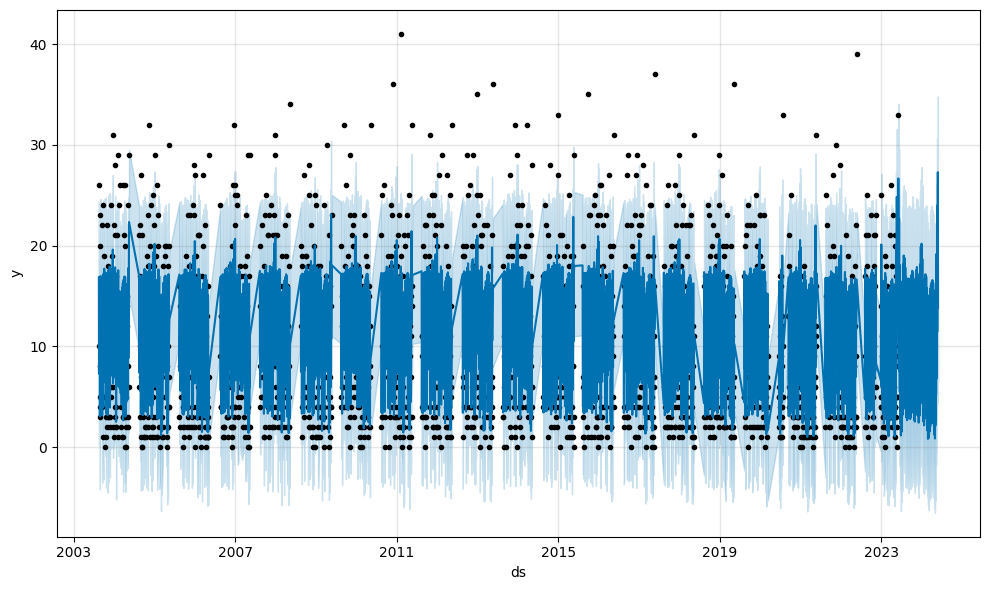

In [14]:
# Now, plot the forecast
fig1 = m.plot(forecast)
#A little bit hard to see. We'll try again with the monthly aggregation

#### Seasonality: use the Prophet.plot_components() method
* By default, plots the overall trend, and the yearly & weekly seasonalities. (Can also include holidays if you want)

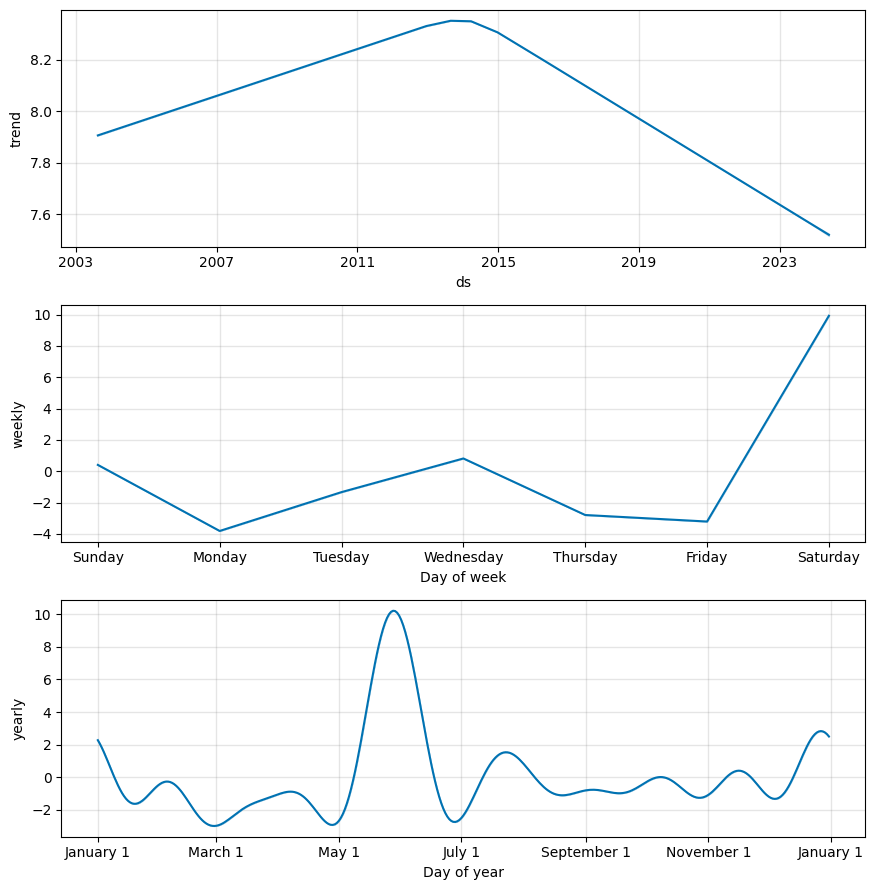

In [15]:
fig2 = m.plot_components(forecast)

#### 1b. Forecasting Number of Goals (monthly projection)

In [16]:
df_goals_monthly = df_stats.groupby('month_year')['Goals'].sum().reset_index()
df_goals_monthly

,month_year,Goals
0,2003-08,103.0
1,2003-09,87.0
2,2003-10,71.0
3,2003-11,92.0
4,2003-12,131.0
...,...,...
194,2023-01,79.0
195,2023-02,93.0
196,2023-03,92.0
197,2023-04,205.0


In [17]:
#change Date to datetime and rename columns to "ds" and "y"
df_goals_monthly['month_year'] = pd.to_datetime(df_goals_monthly['month_year'])


In [18]:
#prophet can't work with period dtype...
#df_goals_monthly['month_year'] = df_goals_monthly['month_year'].dt.to_period('M') 

In [19]:
df_goals_monthly.columns = ['ds','y']

In [20]:
df_goals_monthly

,ds,y
0,2003-08-01,103.0
1,2003-09-01,87.0
2,2003-10-01,71.0
3,2003-11-01,92.0
4,2003-12-01,131.0
...,...,...
194,2023-01-01,79.0
195,2023-02-01,93.0
196,2023-03-01,92.0
197,2023-04-01,205.0


In [21]:
# Python
m = Prophet(weekly_seasonality=True) #try adding the weekly_seasonality=True argument.
m.fit(df_goals_monthly) 

00:51:54 - cmdstanpy - INFO - Chain [1] start processing
00:51:54 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
future = m.make_future_dataframe(periods=12, freq='M') #can predict future periods by month as well by adding the 'freq' argument
future.tail() #predicted into the 2022/2023 season

,ds
206,2023-12-31
207,2024-01-31
208,2024-02-29
209,2024-03-31
210,2024-04-30


In [23]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
206,2023-12-31,108.269439,79.658819,135.804058
207,2024-01-31,97.007267,69.422806,124.622798
208,2024-02-29,91.102052,63.991603,119.465989
209,2024-03-31,132.959232,104.124282,162.081606
210,2024-04-30,83.933496,55.074694,112.593737


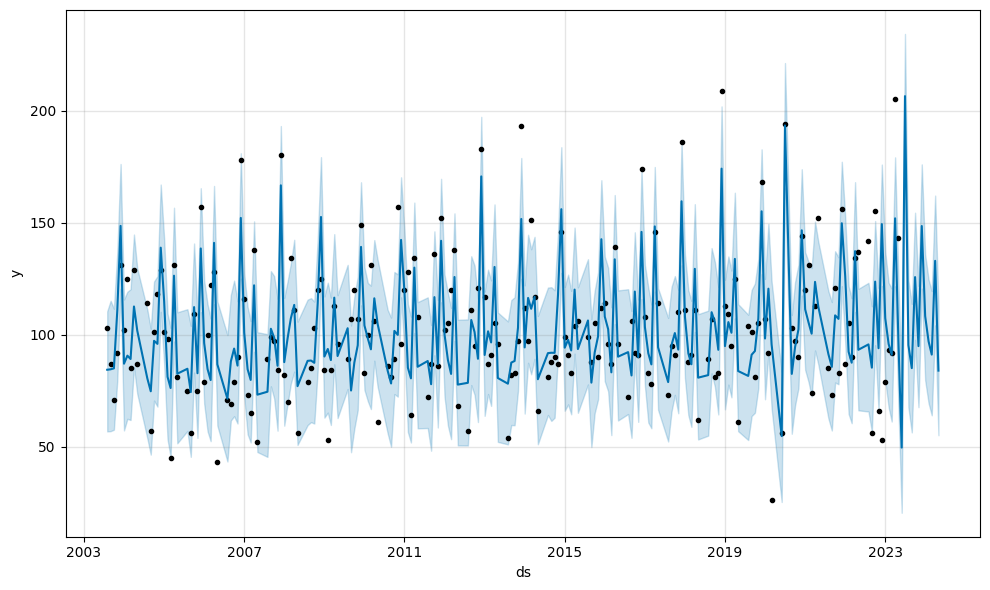

In [24]:
# Now, plot the forecast
fig1 = m.plot(forecast) #makes it a little bit easier to see.

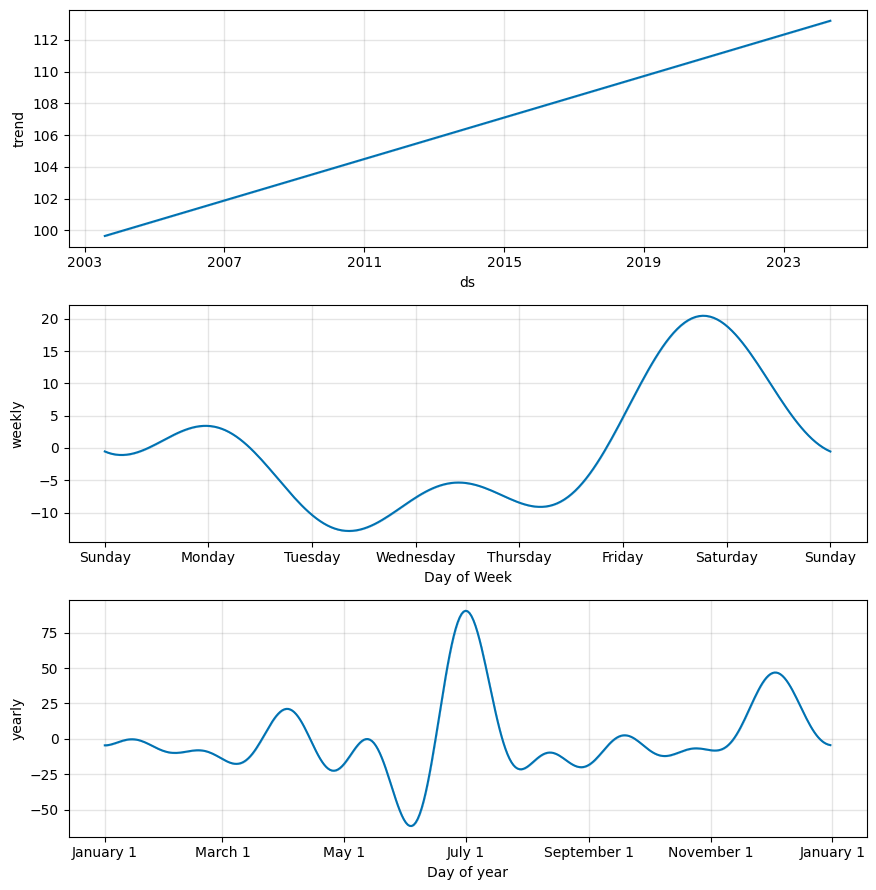

In [25]:
#Try plotting the forecast components
fig2 = m.plot_components(forecast)

#### Summary
* General increasing trends for number of goals the teams are scoring (?)
* Goals tend to be scored more during weekends, naturally because most games are on weekends (limited number of teams participating in more than 1 competition)
* One consideration: take into account the offseason. Address the "peak" visible in the summer

# To see if the patterns are easier to see, look at a single season

In [26]:
df_goals_last_season = df_goals_monthly[df_goals_monthly['ds']>='2022-08-01'] #2022/2023 seasons
df_goals_last_season

,ds,y
189,2022-08-01,142.0
190,2022-09-01,56.0
191,2022-10-01,155.0
192,2022-11-01,66.0
193,2022-12-01,53.0
194,2023-01-01,79.0
195,2023-02-01,93.0
196,2023-03-01,92.0
197,2023-04-01,205.0
198,2023-05-01,143.0


In [27]:
# Python
m = Prophet()
m.fit(df_goals_last_season) #if you get an error here, trying running this in a separate conda environment (not BASE)

00:51:55 - cmdstanpy - INFO - Chain [1] start processing
00:51:55 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
future = m.make_future_dataframe(periods=13, freq='M')
future.tail(10) #predicted into the 2022/2023 season

,ds
13,2023-08-31
14,2023-09-30
15,2023-10-31
16,2023-11-30
17,2023-12-31
18,2024-01-31
19,2024-02-29
20,2024-03-31
21,2024-04-30
22,2024-05-31


In [29]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
18,2024-01-31,177.775243,120.061433,234.013108
19,2024-02-29,182.668893,121.521142,238.923311
20,2024-03-31,187.900036,130.884427,246.161661
21,2024-04-30,192.962432,139.684097,252.211790
22,2024-05-31,198.193574,140.938415,258.779890


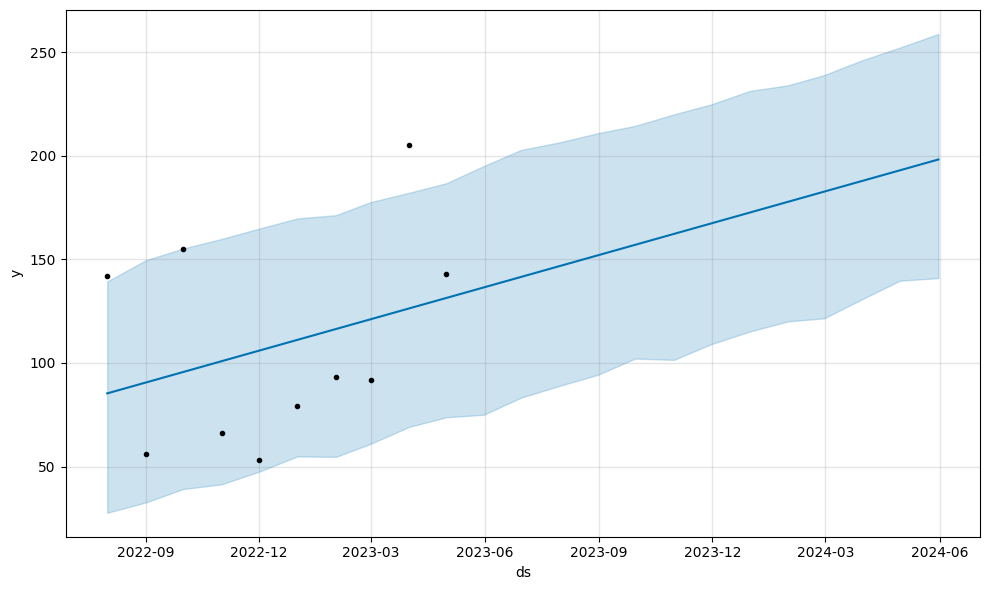

In [30]:
# Now, plot the forecast
fig1 = m.plot(forecast) #makes it a little bit easier to see.

In [31]:
#Try plotting the forecast components
#fig2 = m.plot_components(forecast)
#only includes the trend line due to limited data

#### Generally speaking, more goals were scored in 2021/2022, as the season went on

# To work with more points, do the same but include the 2021/2022 season as well
* looking at last TWO seasons

In [32]:
df_goals_last_two_seasons = df_goals_monthly[df_goals_monthly['ds']>='2021-08-01'] #2021/2022 seasons, 10 months
df_goals_last_two_seasons

,ds,y
179,2021-08-01,85.0
180,2021-09-01,73.0
181,2021-10-01,121.0
182,2021-11-01,83.0
183,2021-12-01,156.0
184,2022-01-01,87.0
185,2022-02-01,105.0
186,2022-03-01,90.0
187,2022-04-01,134.0
188,2022-05-01,137.0


In [33]:
# Python
m = Prophet()
m.fit(df_goals_last_two_seasons) #if you get an error here, trying running this in a separate conda environment (not BASE)

00:51:56 - cmdstanpy - INFO - Chain [1] start processing
00:51:56 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
future = m.make_future_dataframe(periods=13, freq='M')
future.tail(10) #predicted into the 2022/2023 season

,ds
23,2023-08-31
24,2023-09-30
25,2023-10-31
26,2023-11-30
27,2023-12-31
28,2024-01-31
29,2024-02-29
30,2024-03-31
31,2024-04-30
32,2024-05-31


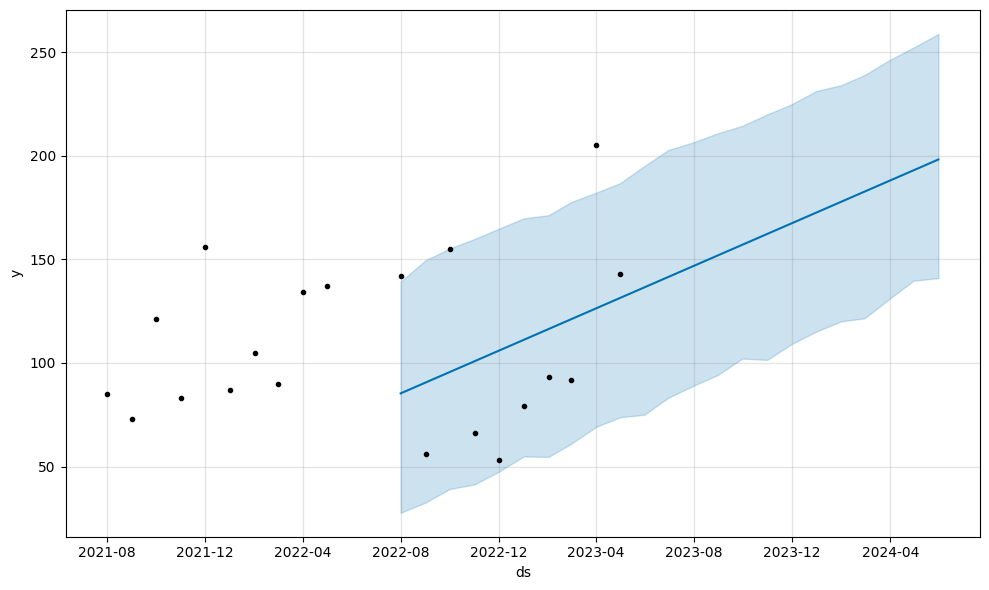

In [35]:
# Now, plot the forecast
fig1 = m.plot(forecast) #makes it a little bit easier to see.

In [36]:
#fig2 = m.plot_components(forecast) #same as earlier, only shows the trend line
#Not sure why the trend line starts at 2021-08